In [92]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
import glob
import os
from os.path import expanduser
import re

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set();

from sklearn.preprocessing import *

In [159]:
home = expanduser("~")
path2data = home + '/.kaggle/competitions/recruit-restaurant-visitor-forecasting/'

## Download Dataset

In [160]:
if  not os.path.exists(path2data):
    !pip install kaggle
    !kaggle competitions download -c recruit-restaurant-visitor-forecasting -p ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting
    !cd ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting && ls && unzip "*.zip"
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [161]:
files = glob.glob(path2data + '*.csv')
files

['/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/date_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/sample_submission.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_store_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_reserve.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/hpg_store_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_visit_data.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/store_id_relation.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/hpg_reserve.csv']

## Data Loading

In [162]:
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob( path2data +'*.csv')}
for k, v in dfs.items(): locals()[k] = v

In [163]:
for k,v in  dfs.items(): print(k)

date_info
sample_submission
air_store_info
air_reserve
hpg_store_info
air_visit_data
store_id_relation
hpg_reserve


**Date info** carry out information about the calendary. Has proposed by [zeemeen](https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st) we have created a new feature **Weight** which creates a podenration factor around the days that are holidays.

In [164]:
wkend_holidays = date_info.apply(lambda x: (x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1, axis=1)
wkend_holidays.value_counts()

date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5

In [165]:
date_info.head(5)

,calendar_date,day_of_week,holiday_flg,weight
0,2016-01-01,Friday,1,2.707368e-14
1,2016-01-02,Saturday,0,8.663577e-13
2,2016-01-03,Sunday,0,6.578904e-12
3,2016-01-04,Monday,0,2.772345e-11
4,2016-01-05,Tuesday,0,8.460525e-11


**air_store_info** contains information about select air restaurants.

In [166]:
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


**air_visit_data** structure contains historical visit data for the air restaurants. It has basicaly the id of the reservation using the air system, visit_date and the number of visitors. In order to combine the provided informations with the new feature we have created a new structure **visitors**. 

In [167]:
visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)

visit_data['visitors_log'] = visit_data.visitors.map(pd.np.log1p)

Text(0.5,1,'Log Visitors distribution')

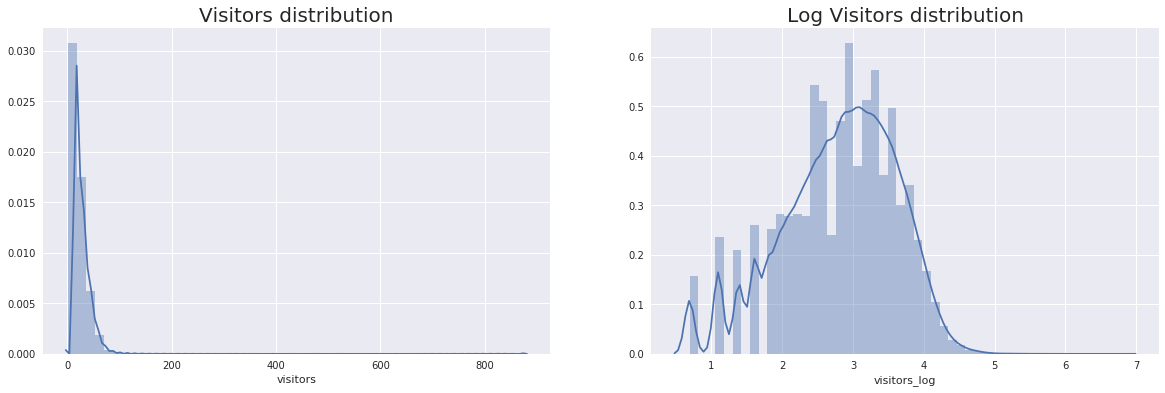

In [168]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.distplot(visit_data['visitors'])
plt.title('Visitors distribution', fontsize=20)

plt.subplot(1,2,2)
sns.distplot(visit_data['visitors_log'])
plt.title('Log Visitors distribution', fontsize=20)

In [169]:
visit_data.head(5)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,weight,visitors_log
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,1.005227e-08,3.258097
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,1.456087e-08,3.496508
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,2.055908e-08,3.401197
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,2.838881e-08,3.135494
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,5.115756e-08,1.945910


In [170]:
visit_data[['visitors', 'visitors_log']].describe()

,visitors,visitors_log
count,252108.000000,252108.000000
mean,20.973761,2.802788
std,16.757007,0.807726
min,1.000000,0.693147
25%,9.000000,2.302585
50%,17.000000,2.890372
75%,29.000000,3.401197
max,877.000000,6.777647


In order to create a more robust model, we have used information about the [weather](https://www.kaggle.com/huntermcgushion/rrv-weather-data). The cell bellow will download automatically this dataset. To add the precipitation and avg_temperature it will be used the function [add_weather](https://gist.github.com/superMDguy/72689a11746079677ddb0d19f26443a1) as demonstrated bellow.

In [171]:
path2weather = 'raw/weather/'

In [172]:
if  not os.path.exists(path2weather):
    !wget -O rrv-weather-data.zip "https://storage.googleapis.com/kaggle-datasets/7480/12096/rrv-weather-data.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528816610&Signature=kDnX2dX3Pd8VGbR6rqRmDH7XYFjBiKYnz3hoez3AWjv0oUf2vJKLpYKV7zfLb%2FgNJE2kXy9D8%2BNvmNkx4LrJHRvVrIMsGyMe%2FM0x1Z3Kxk6nJMSI9BDZGhsyBSONBKPNdND%2FEHuo2k1T2Wo8tOBu1VOOQlLt8NkblTCBx3ihEvEapCq6UgtfNvYvnE55MI8TBCNLcMBBBUU3Cv251yywybyUTAGRfWfIoc2hcYkrVV0j8EtOCfX5CKrAmvxhnuzLBKvlapIrYmOLRtwjlyFfQh2nWqpQGb7ORj%2BUfTvL3trMgOd06aozbCj4A207p%2FBd2IBEweYElxsgddGdpwaLHg%3D%3D"
    !mkdir -p raw/weather/
    !mv rrv-weather-data.zip raw/weather/
    !cd raw/weather/ && unzip rrv-weather-data.zip
else:
    print('Weather Dataset already downloaded!')

Weather Dataset already downloaded!


In [192]:
# This is an example of the used weather file
pd.read_csv(path2weather + '1-1-16_5-31-17_Weather/tokyo__tokyo-kana__tonokyo.csv').head()

,calendar_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover
0,2016-01-01,7.5,12.1,3.6,NaN,9.0,11.80,NaN,NaN,2.6,4.5,1022.4,45.0,1025.4,2.5
1,2016-01-02,7.3,13.4,2.6,NaN,7.5,11.59,NaN,NaN,1.9,5.2,1018.6,51.0,1021.5,4.3
2,2016-01-03,9.3,16.2,3.0,NaN,8.3,10.77,NaN,NaN,1.4,7.0,1013.2,61.0,1016.2,5.3
3,2016-01-04,9.2,15.2,4.4,NaN,8.9,11.19,NaN,NaN,1.6,6.8,1010.4,60.0,1013.3,0.0
4,2016-01-05,10.9,15.4,5.1,NaN,8.4,10.57,NaN,NaN,1.8,6.5,1013.1,51.0,1016.0,2.8


In [173]:
def add_weather(dataset, path2weather='raw/weather/'):                                                                                                                     
    print('Adding weather...')                                                                                                                
    air_nearest = pd.read_csv(                                                                                                                
        path2weather + 'air_store_info_with_nearest_active_station.csv')                                                              
    unique_air_store_ids = list(dataset.air_store_id.unique())                                                                                
                                                                                                                                              
    weather_dir = path2weather + '1-1-16_5-31-17_Weather/'                                                                            
    weather_keep_columns = ['precipitation', 'avg_temperature']                                                                                                                         
                                                                                                                                              
    dataset_with_weather = dataset.copy()                                                                                                     
    for column in weather_keep_columns:                                                                                                       
        dataset_with_weather[column] = np.nan
        
    for air_id in unique_air_store_ids:                                                                                                       
        station = air_nearest[air_nearest.air_store_id == air_id].station_id.iloc[0]  
        weather_data = pd.read_csv(weather_dir + station + '.csv', parse_dates=['calendar_date']).rename(columns={'calendar_date': 'visit_date'})                                                                                                                                               
        
        #change datetime format
        weather_data['visit_date'] = weather_data['visit_date'].dt.strftime('%Y-%m-%d')
        this_store = dataset.air_store_id == air_id                                                                                           
        merged = dataset[this_store].merge(weather_data, on='visit_date', how='left')                                                         
        for column in weather_keep_columns:                                                                                                   
            dataset_with_weather.loc[this_store, column] = merged[column]           
    

        
    return dataset_with_weather    

In [174]:
air_store_info_with_active_station = pd.read_csv(path2weather + 'air_store_info_with_nearest_active_station.csv')

In [175]:
visit_data = pd.merge(left=visit_data, right=air_store_info_with_active_station, on='air_store_id', how='left')

In [176]:
visit_data = add_weather(visit_data)

Adding weather...


In [184]:
# Handle missing data
# We could replace this block by the avg_temperature and precipitation of stations which are closer

visit_data['precipitation'].fillna(visit_data.precipitation.mean(), inplace=True)
visit_data['avg_temperature'].fillna(visit_data.avg_temperature.mean(), inplace=True)

In [185]:
visit_data

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,weight,visitors_log,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,precipitation,avg_temperature
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,1.005227e-08,3.258097,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,8.441176,4.300000
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,1.456087e-08,3.496508,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,8.441176,6.000000
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,2.055908e-08,3.401197,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,0.000000,5.600000
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,2.838881e-08,3.135494,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,8.441176,6.500000
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,5.115756e-08,1.945910,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,67.000000,2.800000
5,air_ba937bf13d40fb24,2016-01-19,9,Tuesday,0,6.703711e-08,2.302585,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,0.000000,5.100000
6,air_ba937bf13d40fb24,2016-01-20,31,Wednesday,0,8.663577e-08,3.465736,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,8.441176,4.100000
7,air_ba937bf13d40fb24,2016-01-21,21,Thursday,0,1.105716e-07,3.091042,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,8.441176,5.400000
8,air_ba937bf13d40fb24,2016-01-22,18,Friday,0,1.395278e-07,2.944439,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,8.441176,5.800000
9,air_ba937bf13d40fb24,2016-01-23,26,Saturday,0,1.742555e-07,3.295837,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,0.000000,3.900000


In [186]:
print('Dataset shape: {}'.format(visit_data.shape))

Dataset shape: (252108, 20)


In [187]:
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(lambda x:( (x.weight * x.visitors_log).sum() / x.weight.sum() )).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) 

In [188]:
visitors.head(5)

,air_store_id,day_of_week,holiday_flg,visitors
0,air_00a91d42b08b08d9,Friday,0,3.583535
1,air_00a91d42b08b08d9,Monday,0,3.203625
2,air_00a91d42b08b08d9,Monday,1,3.091042
3,air_00a91d42b08b08d9,Saturday,0,2.524065
4,air_00a91d42b08b08d9,Sunday,0,1.098612


Text(0.5,1,'Visitors Distribution')

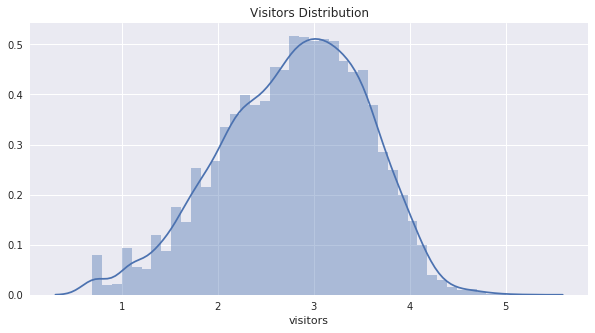

In [189]:
plt.figure(figsize=(10,5))
sns.distplot(visitors['visitors'])
#plt.xscale('log')
plt.title("Visitors Distribution")

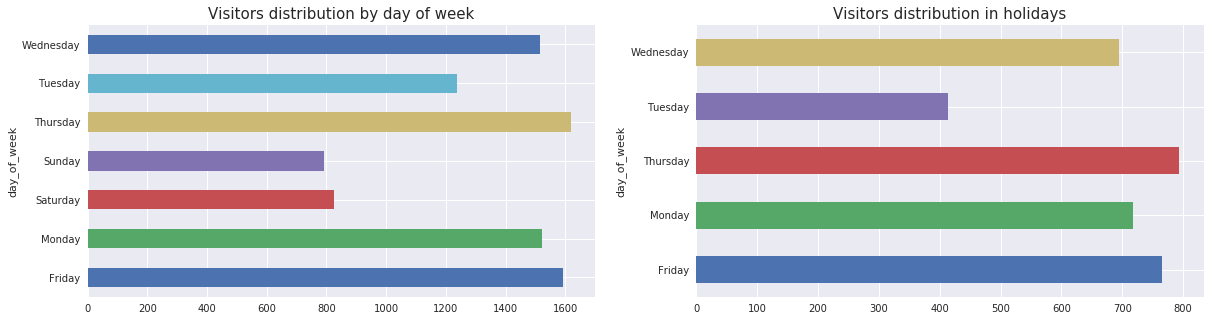

In [190]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Visitors distribution by day of week', fontsize=15)
visitors.groupby('day_of_week')['visitors'].count().plot(kind = 'barh')
plt.subplot(1,2,2)
plt.title('Visitors distribution in holidays', fontsize=15)
visitors[visitors['holiday_flg']==1].groupby('day_of_week')['visitors'].count().plot(kind = 'barh')